In [1]:
import os
# os.environ['MUSDB_PATH'] = '/home/ec2-user/proj/data/data/' # '/root/MUSDB18/MUSDB18-7' # <- change to local dataset path

import sys
sys.path.append(os.path.abspath('../'))

In [2]:
import musdb

mus_train = musdb.DB(subsets="train", split='train')
mus_valid = musdb.DB(subsets="train", split='valid')

In [3]:
len(mus_train.tracks)

86

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics.functional import signal_distortion_ratio
from torchinfo import summary
import musdb, museval
import torch
import transforms
import utils
from mmdensenet import MMDenseNet
from datasets import SamplingTrackDataset, FullTrackDataset
from augmentation import freq_mask
from tqdm.notebook import tqdm

torch.cuda.device_count()

1

In [5]:
seed = 42

torch.manual_seed(seed)
rng = np.random.default_rng(seed)

train_size, valid_size = 86, 14
sample_length_seconds = 5
sample_length_seconds_valid = 15
batch_size = 8
valid_batch_size = 8

In [6]:
training_data = SamplingTrackDataset(mus_train.tracks[:train_size], seconds=sample_length_seconds, target='vocals', rng=rng)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

In [7]:
valid_data = FullTrackDataset(mus_valid.tracks[:valid_size], seconds=sample_length_seconds_valid, target='vocals')
valid_loader = DataLoader(valid_data, batch_size=valid_batch_size)

In [8]:
in_channels, num_features = 2, 32

# growth_rate = [12,12,12,12,12,12,12]
growth_rate = [10,10,10,10,10,10,10]
kernel_size = 3

dilated = [True] * len(growth_rate)
norm = [True] * len(growth_rate)
nonlinear = [True] * len(growth_rate)
# depth = [4,4,4,4,4,4,4]
depth = [3,3,3,3,3,3,3]

growth_rate_final=4
kernel_size_final=3
depth_final=2
dilated_final=True
norm_final=True
nonlinear_final=True

model = MMDenseNet(in_channels, num_features, growth_rate, kernel_size, dilated=dilated, norm=norm, nonlinear=nonlinear, depth=depth,
    growth_rate_final=growth_rate_final, kernel_size_final=kernel_size_final, depth_final=depth_final,
    dilated_final=dilated_final, norm_final=norm_final, nonlinear_final=nonlinear_final)
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

summary(model)


Layer (type:depth-idx)                                            Param #
MMDenseNet                                                        --
├─BandSplit: 1-1                                                  --
├─ModuleDict: 1-2                                                 --
│    └─MDenseNetBackbone: 2-1                                     --
│    │    └─Conv2d: 3-1                                           608
│    │    └─Encoder: 3-2                                          22,544
│    │    └─DenseBlock: 3-3                                       5,520
│    │    └─Decoder: 3-4                                          26,010
│    └─MDenseNetBackbone: 2-2                                     --
│    │    └─Conv2d: 3-5                                           608
│    │    └─Encoder: 3-6                                          22,544
│    │    └─DenseBlock: 3-7                                       5,520
│    │    └─Decoder: 3-8                                          26,010
│    

In [9]:
def step(optimizer, train_loss, model, input, target):
    optimizer.zero_grad()
    # magnitude, phase = torch.abs(mixture), torch.angle(mixture)
    # outputs = model(magnitude) * torch.exp(1j * phase)
    outputs = model(torch.abs(input))

    loss = loss_fn(outputs, torch.abs(target))
    loss.backward()
    optimizer.step()
    
    train_loss.append(loss.item())

In [10]:
epochs = 150
train_losses, valid_losses = [], []

for epoch in tqdm(range(epochs)):

    model.train()
    train_loss = []
    for i, (mixture, target) in enumerate(train_loader):

        step(optimizer, train_loss, model, freq_mask(mixture, F=2049, rng=rng), target)
    
    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for i, (mixture, target) in enumerate(valid_loader):

                outputs = model(torch.abs(mixture))

                loss = loss_fn(outputs, torch.abs(target))
                valid_loss.append(loss.item())

        valid_loss = np.mean(valid_loss)
        valid_losses.append(valid_loss)
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f'epoch {epoch}: train loss {train_loss:3f} valid loss {valid_loss:3f}')
    else:
        print(f'epoch {epoch}: train loss {train_loss:3f}')

    if (epoch + 1) % 20 == 0:
        model_path = os.path.join('../../models/mmdensenet_aug', f'trained_model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_path)
        

  0%|          | 0/150 [00:00<?, ?it/s]

epoch 0: train loss 5.359137 valid loss 4.535535
epoch 1: train loss 3.672549
epoch 2: train loss 4.184506
epoch 3: train loss 3.503939
epoch 4: train loss 2.652232
epoch 5: train loss 2.692697
epoch 6: train loss 3.031786
epoch 7: train loss 3.804566
epoch 8: train loss 2.835952
epoch 9: train loss 3.621301 valid loss 2.478417
epoch 10: train loss 2.826359
epoch 11: train loss 2.396114
epoch 12: train loss 2.390380
epoch 13: train loss 2.028743
epoch 14: train loss 3.569543
epoch 15: train loss 2.517324
epoch 16: train loss 2.347877
epoch 17: train loss 3.414886
epoch 18: train loss 3.735929
epoch 19: train loss 2.840268 valid loss 1.701368
epoch 20: train loss 2.338334
epoch 21: train loss 3.042825
epoch 22: train loss 2.623334
epoch 23: train loss 2.903849
epoch 24: train loss 2.749571
epoch 25: train loss 3.254772
epoch 26: train loss 3.221180
epoch 27: train loss 2.560276
epoch 28: train loss 2.101268
epoch 29: train loss 2.518541 valid loss 2.162359
epoch 30: train loss 2.510436


In [11]:
model_path = os.path.join('../../models/mmdensenet_aug', f'trained_model_epoch_{epochs}.pt')
torch.save(model.cpu().state_dict(), model_path)
torch.save(model.get_config(), os.path.join('../../models/mmdensenet_aug', f'model_config.pt'))
print(f'Done, model saved at {model_path}')

Done, model saved at ../../models/mmdensenet_aug/trained_model_epoch_150.pt


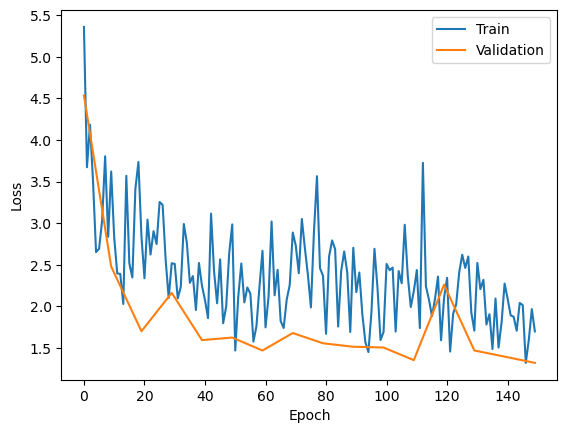

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train')
plt.plot([0,9,19,29,39,49,59,69,79,89,99,109,119,129,139,149], valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [5]:
model = MMDenseNet.build_model('../../models/mmdensenet_aug/model_config.pt')
model.load_state_dict(torch.load('../../models/mmdensenet_aug/trained_model_epoch_150.pt'))
model.eval()

MMDenseNet(
  (bandsplit): BandSplit()
  (net): ModuleDict(
    (low): MDenseNetBackbone(
      (conv2d): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
      (encoder): Encoder(
        (net): Sequential(
          (0): DownSampleDenseBlock(
            (dense_block): DenseBlock(
              (net): Sequential(
                (0): ConvBlock2d(
                  (norm2d): BatchNorm2d(32, eps=1e-12, momentum=0.1, affine=True, track_running_stats=True)
                  (nonlinear2d): ReLU()
                  (conv2d): Conv2d(32, 30, kernel_size=(3, 3), stride=(1, 1))
                )
                (1): ConvBlock2d(
                  (norm2d): BatchNorm2d(10, eps=1e-12, momentum=0.1, affine=True, track_running_stats=True)
                  (nonlinear2d): ReLU()
                  (conv2d): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
                )
                (2): ConvBlock2d(
                  (norm2d): BatchNorm2d(10, eps=1e-12, momentum=0.1, affine=

In [13]:
import scipy.io.wavfile

model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i, track in tqdm(enumerate(mus_valid.tracks)):
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 60., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr)

print(np.mean(sdrs))

0it [00:00, ?it/s]

0 ANiMAL - Rockshow
2.696162855040671
1 Actions - One Minute Smile
3.930365071252355
2 Alexander Ross - Goodbye Bolero
4.57962198461588
3 Clara Berry And Wooldog - Waltz For My Victims
1.7355293819284539
4 Fergessen - Nos Palpitants
9.935582820072918
5 James May - On The Line
7.637559275077889
6 Johnny Lokke - Promises & Lies
6.562029205870049
7 Leaf - Summerghost
6.2920226087880184
8 Meaxic - Take A Step
5.378464309666137
9 Patrick Talbot - A Reason To Leave
6.909690774805728
10 Skelpolu - Human Mistakes
-0.22282672482544524
11 Traffic Experiment - Sirens
0.4998888494016471
12 Triviul - Angelsaint
5.636305064441693
13 Young Griffo - Pennies
6.290634080654786
4.847216396913628


In [15]:
print("validation results")
print("mean:", np.mean(sdrs))
print("median:", np.median(sdrs))
print("std:", np.std(sdrs))

validation results
mean: 4.847216396913628
median: 5.507384687053915
std: 2.7486895479827353


In [16]:
mus_test = musdb.DB(subsets="test")

model.cuda()
model.eval()
sdrs = []
preds, targets = [], []
with torch.no_grad():
    for i in tqdm(range(len(mus_test.tracks))):
        track = mus_test.tracks[i]
        print(i, track)
        mixture_track, target_track, pred_track = [], [], []
        for (mixture_audio, target_audio) in utils.slice_musdb_track_iterator(track, 60., sample_targets='vocals'):
            mixture = transforms.stft(torch.tensor(mixture_audio[None], dtype=torch.float))
            output = model(torch.abs(mixture)) * torch.exp(1j * torch.angle(mixture))
            pred_audio = transforms.istft(output, device='cpu')[0]
            pred_track.append(pred_audio)
            mixture_track.append(torch.tensor(mixture_audio[:,:pred_audio.size(-1)], device='cpu'))
            target_track.append(torch.tensor(target_audio[:,:pred_audio.size(-1)], device='cpu'))

        mixture_track = torch.cat(mixture_track, dim=1).numpy().T
        target_track = torch.cat(target_track, dim=1).numpy().T
        pred_track = torch.cat(pred_track, dim=1).numpy().T

        sdr, _, _, _ = museval.metrics.bss_eval_sources([target_track], [pred_track], compute_permutation=False)
        print(sdr[0][0])
        sdrs.append(sdr[0][0])

sdr = np.mean(sdrs)
print('final sdr', sdr)

  0%|          | 0/50 [00:00<?, ?it/s]

0 AM Contra - Heart Peripheral
7.028032296663213
1 Al James - Schoolboy Facination
3.789144272194889
2 Angels In Amplifiers - I'm Alright
5.680069052584984
3 Arise - Run Run Run
3.0455977088785264
4 BKS - Bulldozer
2.206199439775151
5 BKS - Too Much
7.326473563693493
6 Ben Carrigan - We'll Talk About It All Tonight
2.208535503244982
7 Bobby Nobody - Stitch Up
4.013030096824587
8 Buitraker - Revo X
-0.08786565378976112
9 Carlos Gonzalez - A Place For Us
3.745230639204064
10 Cristina Vane - So Easy
6.59354156336414
11 Detsky Sad - Walkie Talkie
2.5497008307767324
12 Enda Reilly - Cur An Long Ag Seol
6.577220062778025
13 Forkupines - Semantics
2.6630050103067577
14 Georgia Wonder - Siren
0.4740476448852964
15 Girls Under Glass - We Feel Alright
2.1027224306482712
16 Hollow Ground - Ill Fate
2.655150865460048
17 James Elder & Mark M Thompson - The English Actor
5.1724192112031595
18 Juliet's Rescue - Heartbeats
5.533936049070254
19 Little Chicago's Finest - My Own
5.2452335303940565
20 Lou

In [17]:
print("test results")
print("mean:", np.mean(sdrs))
print("median:", np.median(sdrs))
print("std:", np.std(sdrs))

test results
mean: 3.7303697682840653
median: 4.39409116869362
std: 4.224416029668189
